In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "******"
os.environ['KAGGLE_KEY'] = "******"
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p data/


In [ ]:
!unzip -o data/amazon-books-reviews.zip -d data/

In [70]:
import os
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv("data/Books_rating.csv")
print("Rows, Cols:", df.shape)
print("Columns:", list(df.columns))

Rows, Cols: (3000000, 10)
Columns: ['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']


In [72]:
# Keep only relevant columns
data = df[["User_id", "Id", "Title", "review/score"]].copy()
print("Before cleaning:", data.shape)

Before cleaning: (3000000, 4)


In [73]:
# Drop rows with missing values
data = data.dropna(subset=["User_id", "Id"])

# Remove exact duplicates (same user reviewing same book multiple times)
data = data.drop_duplicates(subset=["User_id", "Id"])
print("After dropping missing and duplicates:", data.shape)


After dropping missing and duplicates: (2397614, 4)


In [74]:
# Create a mapping from book ID to Title
id2title = data.set_index('Id')['Title'].to_dict()

In [75]:
# Group by user (list of book IDs reviewed by each user)
baskets = (
    data.groupby("User_id")["Id"]
         .apply(list)
         .reset_index(name="books")
)

# De-duplicate books within each user's basket
baskets["books"] = baskets["books"].apply(lambda lst: sorted(set(lst)))

# Drop users with fewer than 2 reviewed books (can’t form pairs)
baskets = baskets[baskets["books"].map(len) >= 2].reset_index(drop=True)
print("Baskets:", len(baskets))

Baskets: 308676


In [76]:
# Global frequency pruning

MIN_ITEM_SUPPORT = 0.0015   # ~0.15% of users; adjust 0.001–0.003 if needed
MIN_ITEM_COUNT = max(2, math.ceil(MIN_ITEM_SUPPORT * len(baskets)))

cnt = Counter(b for lst in baskets["books"] for b in lst)
keep = {b for b, c in cnt.items() if c >= MIN_ITEM_COUNT}

baskets["books"] = baskets["books"].apply(lambda lst: [b for b in lst if b in keep])
baskets = baskets[baskets["books"].map(len) >= 2]
print("Baskets:", len(baskets), "Kept items:", len(keep))

Baskets: 66082 Kept items: 472


In [77]:
# One-hot encode for Apriori
transactions = baskets["books"].tolist()
te = TransactionEncoder()
onehot = te.fit(transactions).transform(transactions, sparse=True)
X = pd.DataFrame.sparse.from_spmatrix(onehot, columns=te.columns_).astype(pd.SparseDtype("bool", False))

/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_81846/3900180712.py:5: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X = pd.DataFrame.sparse.from_spmatrix(onehot, columns=te.columns_).astype(pd.SparseDtype("bool", False))


In [78]:
# Run Apriori + association rules
MIN_SUPPORT = 0.008   
MIN_CONFIDENCE = 0.4
MIN_LIFT = 1.2

freq = apriori(X, min_support=MIN_SUPPORT, use_colnames=True, max_len=2)
rules = association_rules(freq, metric="confidence", min_threshold=MIN_CONFIDENCE)
rules = rules[rules["lift"] >= MIN_LIFT].copy()


In [79]:
# Sort rules
rules = rules.sort_values(["lift", "confidence", "support"], ascending=False)
print("Rules found:", len(rules))
display(rules.head(15)[["antecedents", "consequents", "support", "confidence", "lift"]])


Rules found: 2712


,antecedents,consequents,support,confidence,lift
1812,(B0006DXW74),(B00086U8GW),0.008035,1.0,124.448211
1813,(B00086U8GW),(B0006DXW74),0.008035,1.0,124.448211
1814,(B000MY6VHK),(B0006DXW74),0.008035,1.0,124.448211
1815,(B0006DXW74),(B000MY6VHK),0.008035,1.0,124.448211
1816,(B0006DXW74),(B000PC53ZK),0.008035,1.0,124.448211
1817,(B000PC53ZK),(B0006DXW74),0.008035,1.0,124.448211
1978,(B000MY6VHK),(B00086U8GW),0.008035,1.0,124.448211
1979,(B00086U8GW),(B000MY6VHK),0.008035,1.0,124.448211
1980,(B00086U8GW),(B000PC53ZK),0.008035,1.0,124.448211
1981,(B000PC53ZK),(B00086U8GW),0.008035,1.0,124.448211


/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_81846/997894040.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books.values, y=[id2title.get(i, str(i)) for i in top_books.index], palette="viridis")


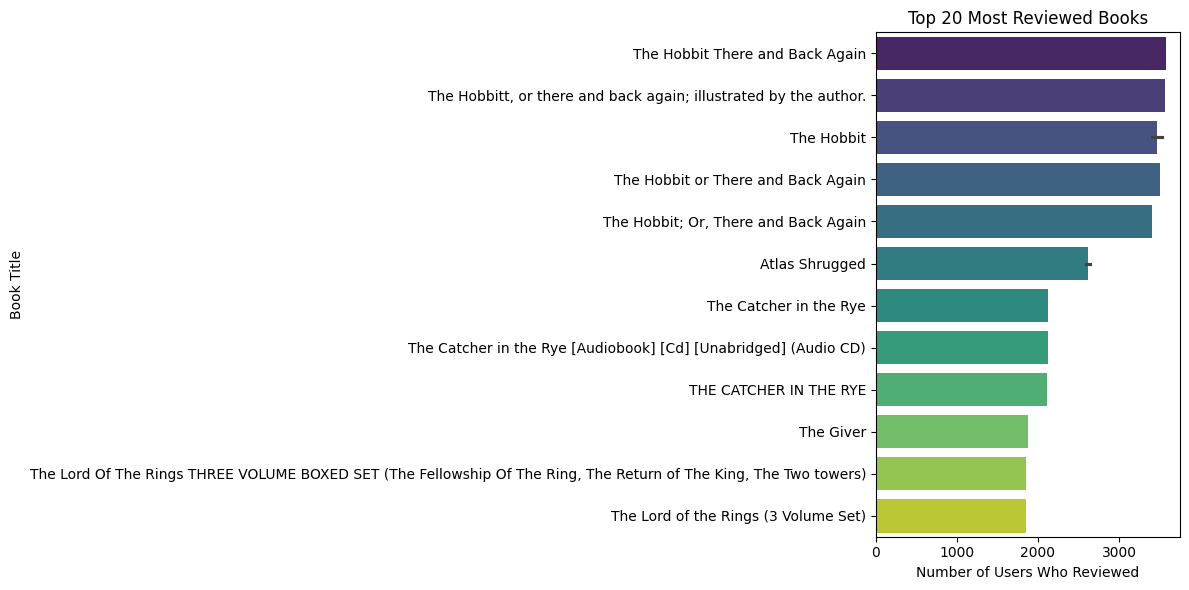

In [80]:
top_books = pd.Series([b for lst in baskets["books"] for b in lst]).value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_books.values, y=[id2title.get(i, str(i)) for i in top_books.index], palette="viridis")
plt.title("Top 20 Most Reviewed Books")
plt.xlabel("Number of Users Who Reviewed")
plt.ylabel("Book Title")
plt.tight_layout()
plt.show()



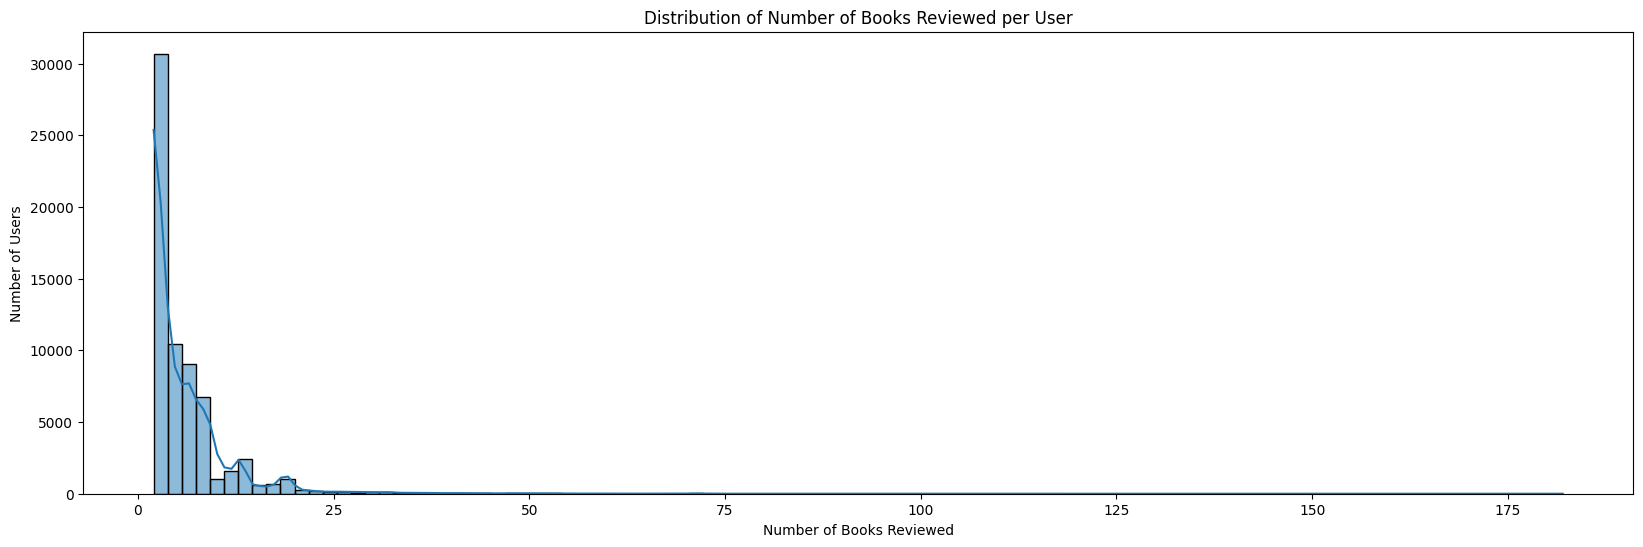

In [81]:
# Distribution of number of books per user
plt.figure(figsize=(20, 6))
sns.histplot(baskets['books'].map(len), bins=100, kde=True)
plt.title('Distribution of Number of Books Reviewed per User')
plt.xlabel('Number of Books Reviewed')
plt.ylabel('Number of Users')
plt.show()